In [306]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

In [307]:
data = np.loadtxt('data/thtg-xfp-thfp.dat')
thtg = data[:, 0]
xfp = data[:, 1]
thfp = data[:, 2]

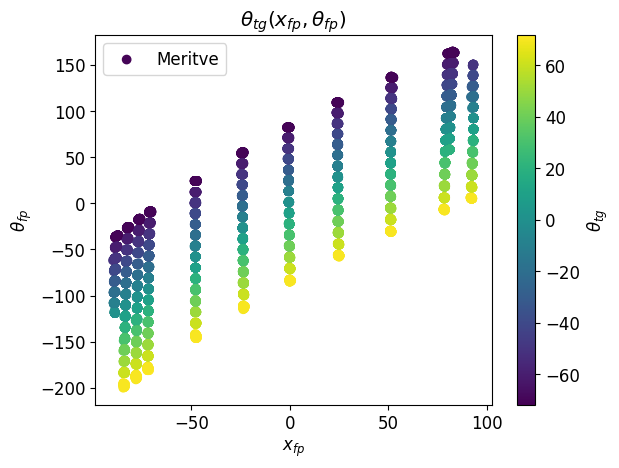

In [308]:
# Create a scatter plot with a colormap
plt.scatter(xfp, thfp, c=thtg, cmap='viridis', marker='o', label='Meritve')

# Add colorbar
plt.colorbar(label=r'$\theta_{tg}$')

# Set labels and title
plt.xlabel(r'$x_{fp}$')
plt.ylabel(r'$\theta_{fp}$')
plt.title(r'$\theta_{tg}(x_{fp}, \theta_{fp})$')
plt.legend()
plt.show()

Model ima obliko 

$
    \theta_{tg}(\theta_{fp}, x_{fp}) = (a_0 + a_1 x_{fp} + a_2 x_{fp}^2) + (a_3 + a_4 x_{fp} + a_5 x_{fp}^2) \theta_{fp}
$

Pripravimo sistem

$
    A\vec{a} = \vec{b},
$

kjer je $\vec{a}$ vektor parametrov $a_1...a_5$. To rešimo s SVD razcepom

In [309]:
N = len(xfp)


def generate_tuples(m):
    tuples_list = []

    for i in range(m):
        for j in range(i + 1):
            tuples_list.append((i - j, j))

    return tuples_list


def prepare_matrix_A(m):
    exponents = generate_tuples(m)
    M = len(exponents)
    A = np.zeros((N, M))
    for i, exp in enumerate(exponents):
        A[:, i] = xfp**exp[0] * thfp**exp[1]

    return A

In [310]:
m = 10

A = prepare_matrix_A(m)
N, M = np.shape(A)
U, W, Vt = np.linalg.svd(A)

C:\Users\Tadej\AppData\Local\Temp\ipykernel_18080\2064778395.py:17: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1, 1].imshow(np.log(np.abs(Vt)), cmap='viridis', interpolation='nearest', origin='upper', aspect='auto')


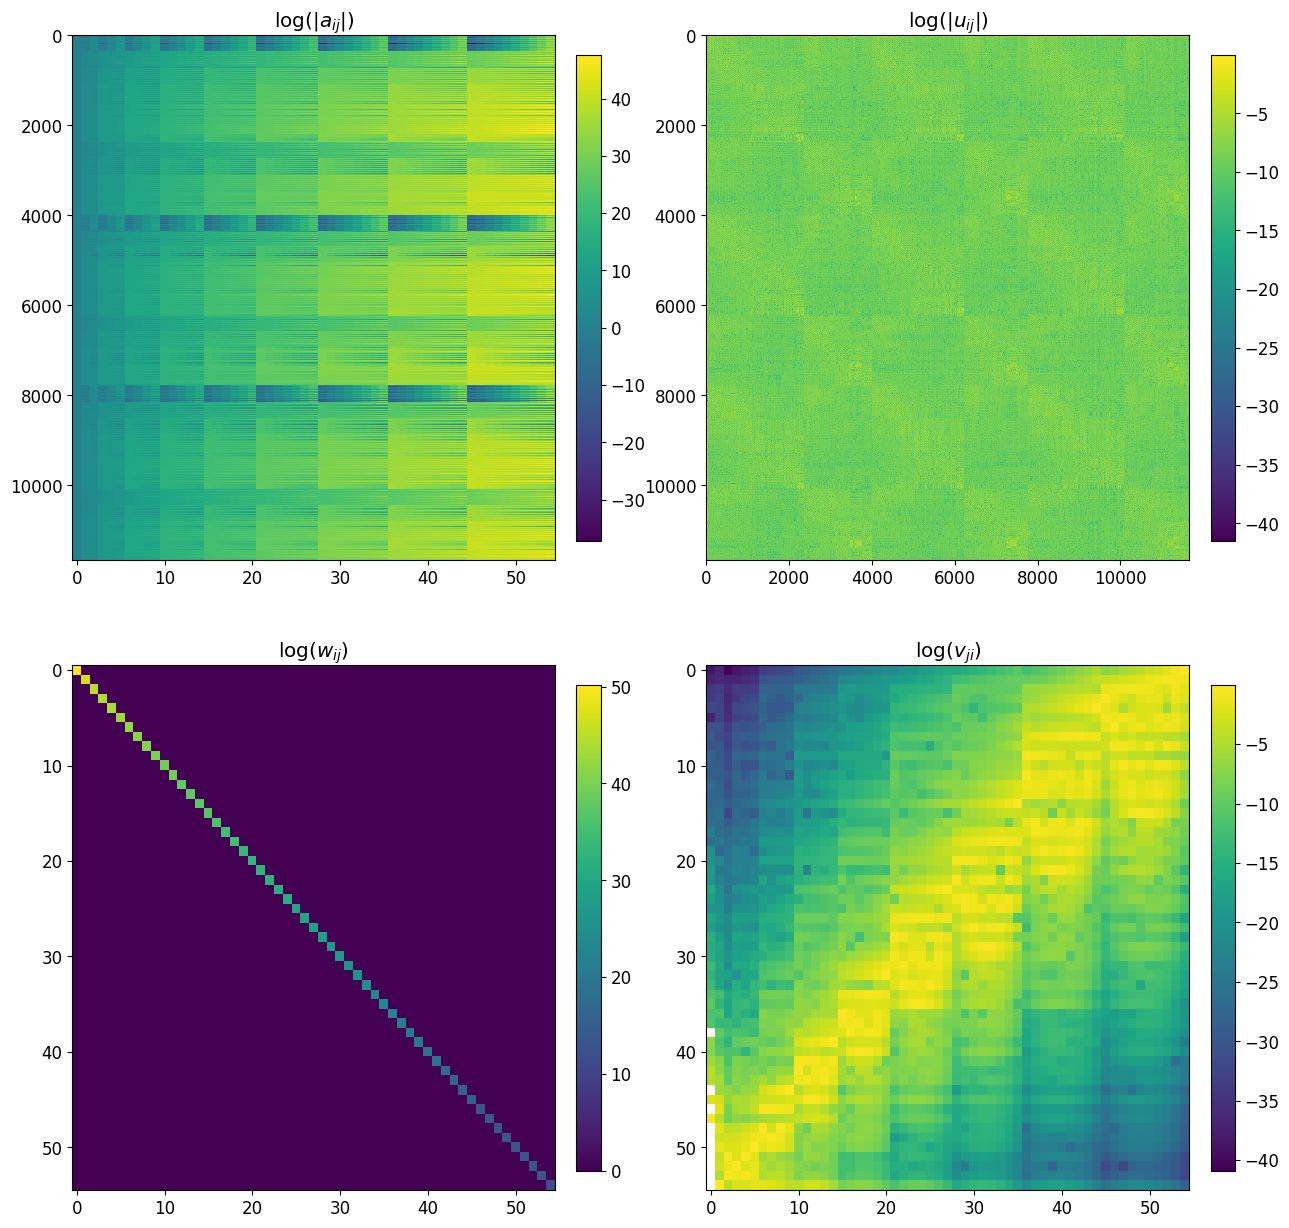

In [311]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot matrices and add colorbars
im1 = axs[0, 0].imshow(np.log(np.abs(A)), cmap='viridis', interpolation='nearest', origin='upper', aspect='auto')
axs[0, 0].set_title(r'log(|$a_{ij}$|)')
cbar1 = fig.colorbar(im1, ax=axs[0, 0], fraction=0.046, pad=0.04)

im2 = axs[0, 1].imshow(np.log(np.abs(U)), cmap='viridis', interpolation='nearest', origin='upper', aspect='auto')
axs[0, 1].set_title(r'log(|$u_{ij}$|)')
cbar2 = fig.colorbar(im2, ax=axs[0, 1], fraction=0.046, pad=0.04)

im3 = axs[1, 0].imshow(np.diag(np.log(W)), cmap='viridis', interpolation='nearest', origin='upper', aspect='auto')
axs[1, 0].set_title(r'log($w_{ij}$)')
cbar3 = fig.colorbar(im3, ax=axs[1, 0], fraction=0.046, pad=0.04)

im4 = axs[1, 1].imshow(np.log(np.abs(Vt)), cmap='viridis', interpolation='nearest', origin='upper', aspect='auto')
axs[1, 1].set_title(r'log($v_{ji}$)')
cbar4 = fig.colorbar(im4, ax=axs[1, 1], fraction=0.046, pad=0.04)

plt.show()

In [312]:
b = thtg

a = np.zeros(M)

for i in range(0, M):
    a = a + np.dot(U[i], b)/W[i] * Vt[i]


acov = np.zeros((M,M))

for j in range(0, M):
    for k in range(0, M):
        for i in range(0, M):
            acov[j][k] = acov[j][k] + (Vt.T)[i][j] * (Vt.T)[i][k] / W[i]**2

# Calculate the standard deviations
std_devs = np.sqrt(np.diag(acov))

# Create the correlation matrix
acor = acov / np.outer(std_devs, std_devs)

In [313]:
print(M)

55


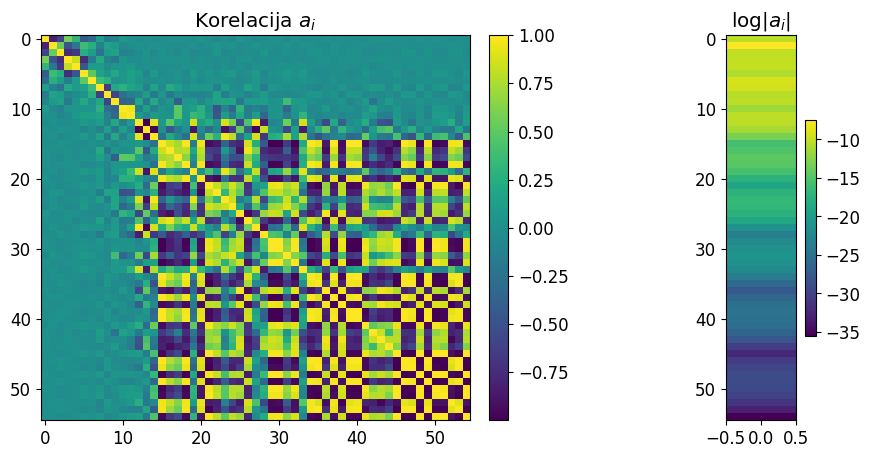

In [314]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3., 1.5]})

# Plot matrices and add colorbars
im0 = axs[0].imshow(acor, cmap='viridis', interpolation='nearest', origin='upper', aspect='auto')
im1 = axs[1].imshow(np.log(np.array([np.abs(a)])).T, cmap='viridis', interpolation='nearest', origin='upper', aspect=0.1)
axs[0].set_title(r'Korelacija $a_i$')
axs[1].set_title(r'log|$a_i$|')
cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

In [315]:
chi2 = np.linalg.norm((np.dot(A, a) - b)/0.3, ord=2)
print(chi2/(N-M))

1.8835614896142168


In [320]:
ms = np.arange(0, 75)
chi2s = np.zeros_like(ms)
Ms = np.zeros_like(ms)
b = thtg

for i, m in enumerate(ms):

    A = prepare_matrix_A(m)
    N, M = np.shape(A)
    U, W, Vt = np.linalg.svd(A)

    a = np.zeros(M)

    for j in range(0, M):
        a = a + np.dot(U[j], b)/W[j] * Vt[j]

    Ms[i] = M
    chi2s[i] = np.linalg.norm((np.dot(A, a) - b), ord=2)

In [321]:
print(Ms)
print(chi2s/(0.3*(N-Ms)))

[   0    1    3    6   10   15   21   28   36   45   55   66   78   91
  105  120  136  153  171  190  210  231  253  276  300  325  351  378
  406  435  465  496  528  561  595  630  666  703  741  780  820  861
  903  946  990 1035 1081 1128 1176 1225 1275 1326 1378 1431 1485 1540
 1596 1653 1711 1770 1830 1891 1953 2016 2080 2145 2211 2278 2346 2415
 2485 2556 2628 2701 2775]
[1.31533076 1.31630087 1.74355456 2.02761815 2.12126412 1.97682403
 1.54156647 1.88020968 1.69748044 1.86718302 1.88343382 1.81423686
 1.68752337 1.88497206 2.10005767 1.8195467  2.11726949 2.02165856
 2.15532742 1.98169935 2.18187109 1.88647892 1.6745531  2.72192466
 1.48584836 1.57613169 1.48842142 1.47308113 1.45276371 1.40308697
 1.38422619 1.36568478 1.38397534 1.35987032 1.36344475 1.45536928
 1.4007334  1.41275923 1.40790919 1.41417853 1.42400492 1.40812045
 1.44923496 1.44198775 1.46448087 1.45688304 1.44904258 1.46404733
 1.44754823 1.49265645 1.47513635 1.48434729 1.48666602 1.4780796
 1.52586771 1.67

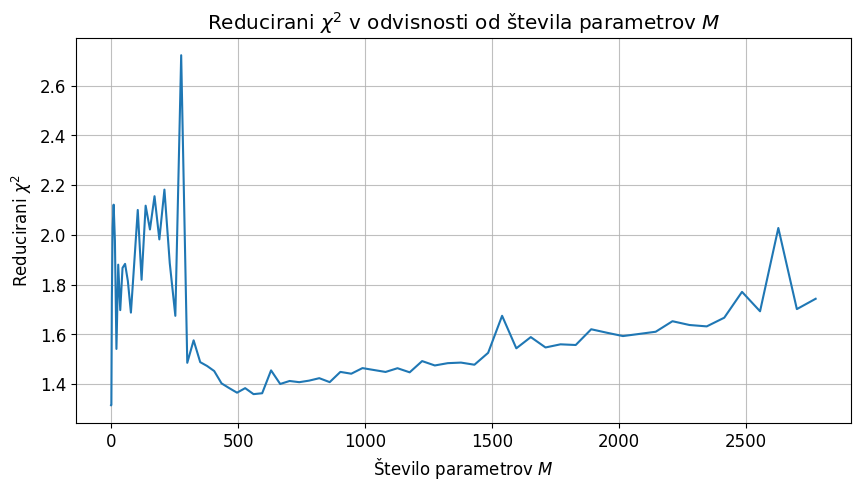

In [324]:
plt.figure(figsize=(10, 5))
plt.grid(alpha=0.8)
plt.title(r'Reducirani $\chi^2$ v odvisnosti od števila parametrov $M$')
plt.xlabel(r'Število parametrov $M$')
plt.ylabel(r'Reducirani $\chi^2$')
plt.plot(Ms, chi2s/(0.3*(N-Ms)))